In [146]:
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from PIL import Image as Image
import torch.utils.data as data
import torchvision.transforms.v2 as tfs
import torch.nn as nn
import torch.optim as optim

In [109]:
#Класс Датасета
class SunDataset(data.Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")
        self.transform = transform
        
        with open(os.path.join(self.path, "format.json"), "r") as file:
            self.format = json.load(file)

        self.files = [os.path.join(self.path, element) for element in self.format.keys()]
        self.targets = list(self.format.values())
        self.len = len(self.files)

    def __getitem__(self, item):
        path_file = self.files[item]
        img = Image.open(path_file).convert("RGB")
        if self.transform:
            img = self.transform(img)
        target = torch.tensor(self.targets[item], dtype=torch.float32)
        return img, target

    def __len__(self):
        return self.len

In [114]:
#Класс нейронной сети
class SunCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2, bias=True), #(10, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #(10, 128, 128)
        )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1, bias=True), #(20, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #(20, 64, 64)
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1, bias=True), #(20, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #(20, 32, 32)
        )

        self.cnn4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1, bias=True), #(20, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #(20, 16, 16)
        )

        self.flatten = nn.Flatten()

        self.linear = nn.Sequential(
            nn.Linear(5120, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.flatten(x)
        return self.linear(x)

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SunCNN()
model.to(device)
model.train()

transform = tfs.Compose([tfs.ToImage(), tfs.ToDtype(dtype=torch.float32, scale=True)])
dataset = SunDataset("dataset_reg", train=True, transform=transform)
train_data = data.DataLoader(dataset, batch_size=32, shuffle=True)

loss_func = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.015, weight_decay=0.0001)

eph = 5
for _e in range(eph):
    mean_loss, lm_count = 0, 0
    tqdm_train_data = tqdm(train_data, leave=True)
    for x_train, y_train in tqdm_train_data:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        predict = model(x_train)
        loss = loss_func(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        mean_loss = 1 / lm_count * loss.item() + (1 - 1 / lm_count) * mean_loss

        tqdm_train_data.set_description(f"Текущая эпоха: [{_e}/{eph}]  Текущая ошибка: {mean_loss}")

Текущая эпоха: [0/5]  Текущая ошибка: 3735.1914409235314: 100%|██████████████████████| 313/313 [01:58<00:00,  2.64it/s]
Текущая эпоха: [1/5]  Текущая ошибка: 93.48560098337283: 100%|███████████████████████| 313/313 [00:39<00:00,  7.98it/s]
Текущая эпоха: [2/5]  Текущая ошибка: 74.3389978835377: 100%|████████████████████████| 313/313 [00:39<00:00,  7.92it/s]
Текущая эпоха: [3/5]  Текущая ошибка: 59.73749452353288: 100%|███████████████████████| 313/313 [00:39<00:00,  7.95it/s]
Текущая эпоха: [4/5]  Текущая ошибка: 54.08089550920184: 100%|███████████████████████| 313/313 [00:39<00:00,  7.95it/s]


In [116]:
#Сохраним модель
state_dict = model.state_dict()
torch.save(state_dict, "model_cnn.tar")

In [128]:
#Посмотрим качество модели на тренировочной выборке
model.eval()
model.to(device)
transform = tfs.Compose([tfs.ToImage(), tfs.ToDtype(dtype=torch.float32, scale=True)])
dataset = SunDataset("dataset_reg", train=True, transform=transform)
train_data = data.DataLoader(dataset, batch_size=32, shuffle=False)
loss_func = nn.MSELoss()
Q_train, cnt = 0, 0

for x_train, y_train in train_data:
    with torch.no_grad():
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        predict = model(x_train)
        cnt += 1
        Q_train += loss_func(predict, y_train)
Q_train /= cnt
print(f"Качество модели на тренировочной выборке: {round(Q_train.item(), 3)}")

Качество модели на тренировочной выборке: 14.155


In [129]:
#Посмотрим качество модели на тестовой выборке
model.eval()
model.to(device)
transform = tfs.Compose([tfs.ToImage(), tfs.ToDtype(dtype=torch.float32, scale=True)])
dataset = SunDataset("dataset_reg", train=True, transform=transform)
test_data = data.DataLoader(dataset, batch_size=32, shuffle=False)
loss_func = nn.MSELoss()
Q_test, cnt = 0, 0

for x_test, y_test in test_data:
    with torch.no_grad():
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        predict = model(x_test)
        cnt += 1
        Q_test += loss_func(predict, y_test)
Q_test /= cnt
print(f"Качество модели на тестовой выборке: {round(Q_test.item(), 3)}")

Качество модели на тестовой выборке: 14.155


In [132]:
#Попробуем дообучить модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SunCNN()
model.load_state_dict(torch.load("model_cnn.tar", weights_only=True))
model.to(device)
model.train()

transform = tfs.Compose([tfs.ToImage(), tfs.ToDtype(dtype=torch.float32, scale=True)])
dataset = SunDataset("dataset_reg", train=True, transform=transform)
train_data = data.DataLoader(dataset, batch_size=32, shuffle=True)

loss_func = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.015, weight_decay=0.0001)

eph = 5
for _e in range(eph):
    mean_loss, lm_count = 0, 0
    tqdm_train_data = tqdm(train_data, leave=True)
    for x_train, y_train in tqdm_train_data:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        predict = model(x_train)
        loss = loss_func(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        mean_loss = 1 / lm_count * loss.item() + (1 - 1 / lm_count) * mean_loss

        tqdm_train_data.set_description(f"Текущая эпоха: [{_e}/{eph}]  Текущая ошибка: {mean_loss}")

Текущая эпоха: [0/5]  Текущая ошибка: 53.48624777870056: 100%|███████████████████████| 313/313 [00:39<00:00,  7.85it/s]
Текущая эпоха: [1/5]  Текущая ошибка: 38.0921267868993: 100%|████████████████████████| 313/313 [00:39<00:00,  7.89it/s]
Текущая эпоха: [2/5]  Текущая ошибка: 39.48978674068997: 100%|███████████████████████| 313/313 [00:39<00:00,  7.85it/s]
Текущая эпоха: [3/5]  Текущая ошибка: 37.85479615519225: 100%|███████████████████████| 313/313 [00:39<00:00,  7.95it/s]
Текущая эпоха: [4/5]  Текущая ошибка: 32.935034323043354: 100%|██████████████████████| 313/313 [00:39<00:00,  7.92it/s]


In [133]:
#Посмотрим качество модели на тренировочной выборке
model.eval()
model.to(device)
transform = tfs.Compose([tfs.ToImage(), tfs.ToDtype(dtype=torch.float32, scale=True)])
dataset = SunDataset("dataset_reg", train=True, transform=transform)
train_data = data.DataLoader(dataset, batch_size=32, shuffle=False)
loss_func = nn.MSELoss()
Q_train, cnt = 0, 0

for x_train, y_train in train_data:
    with torch.no_grad():
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        predict = model(x_train)
        cnt += 1
        Q_train += loss_func(predict, y_train)
Q_train /= cnt
print(f"Качество модели на тренировочной выборке: {round(Q_train.item(), 3)}")

Качество модели на тренировочной выборке: 10.707


In [137]:
#Посмотрим качество модели на тестовой выборке
model.eval()
model.to(device)
transform = tfs.Compose([tfs.ToImage(), tfs.ToDtype(dtype=torch.float32, scale=True)])
dataset = SunDataset("dataset_reg", train=False, transform=transform)
test_data = data.DataLoader(dataset, batch_size=32, shuffle=False)
loss_func = nn.MSELoss()
Q_test, cnt = 0, 0

for x_test, y_test in test_data:
    with torch.no_grad():
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        predict = model(x_test)
        cnt += 1
        Q_test += loss_func(predict, y_test)
Q_test /= cnt
print(f"Качество модели на тестовой выборке: {round(Q_test.item(), 3)}")

Качество модели на тестовой выборке: 11.543


In [138]:
#Снова сохраним модель
#Сохраним модель
state_dict = model.state_dict()
torch.save(state_dict, "model_cnn2.tar")

tensor([[219.4346, 155.2558]], grad_fn=<AddmmBackward0>)
[221, 159]


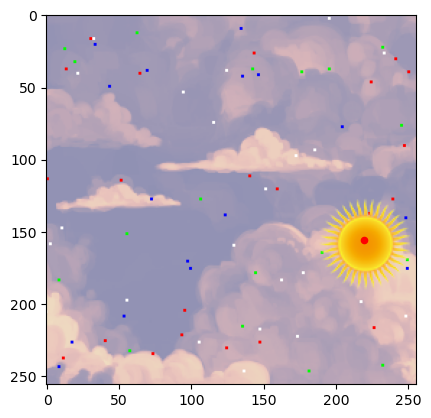

In [150]:
#Результат модели
model.to("cpu")
path = 'dataset_reg/test/'
num_img = 999

st = torch.load('model_cnn2.tar', weights_only=False)
model.load_state_dict(st)

with open(os.path.join(path, "format.json"), "r") as fp:
    format = json.load(fp)

transforms = tfs.Compose([tfs.ToImage(), tfs.ToDtype(torch.float32, scale=True)])
img = Image.open(os.path.join(path, f'sun_reg_{num_img}.png')).convert('RGB')
img_t = transforms(img).unsqueeze(0)

model.eval()
predict = model(img_t)
print(predict)
print(tuple(format.values())[num_img-1])
p = predict.detach().squeeze().numpy()

plt.imshow(img)
plt.scatter(p[0], p[1], s=20, c='r')
plt.show()